In [2]:
## Architecture

# Take in inputs from the screen and preprocess them
# Pass them into an NN
# Update the weights of the NN using gradient descent
# weights['1'] - Matrix that holds weights of pixels passing into hidden layer. Dimensions: [200 x 80 x 80] -> [200 x 6400]
# weights['2'] - Matrix that holds weights of hidden layer passing into output. Dimensions: [1 x 200]

# Process is:

# processed_observations = image vector - [6400 x 1] array
# Compute hidden_layer_values = weights['1'] dot processed_observations ([200 x 6400] dot [6400 x 1]) -> [200 x 1] 
# - this gives initial activation values.
# Next we need to transform those either via a sigmoid or an ReLU of some sort. Let's use ReLU
# ReLU(hidden_layer_values)
# Next we need to pass this one layer further
# output_layer_value = weights['2'] dot hidden_layer_values ([1 x 200] dot [200 x 1] -> [1 x 1])
# Now our output layer is the probability of going up or down. Let's make sure this output is between 0 and 1 by passing it 
# through a sigmoid
# p = sigmoid(output_layer_value)

# Learning after round has finished:

# Figure out the result
# Compute the error
# Use the error to calculate the gradient
    # The below dimensions all assume we had exactly 10 frames in the round (not necessarily true!)
    # dC_dw2 = hidden_layer_values^T dot gradient_log_p ([1 x 2000] dot [2000 x 1] -> 1x1)
    # delta_1 = gradient_log_p outer_product weights['2'] = [2000 x 1] outer_product [1 x 200] ([2000 x 200])
    # dC_dw1 = delta_1^T dot input_observations ([200 x 2000]x dot [2000 x 64000] -> [200 x 64000])

# After some batch size of rounds has finished,
    # Use rmsprop to move weights['1'] and weights['2'] in the direction of the gradient
# Repeat!

import gym
import numpy as np
import cv2
from matplotlib import pyplot as plt

def downsample(image):
    # Take only alternate pixels - basically halves the resolution of the image (which is fine for us)
    return image[::2, ::2, :]

def remove_color(image):
    """Convert all color (RGB is the third dimension in the image)"""
    return image[:, :, 0]

def remove_background(image):
    image[image == 144] = 0
    image[image == 109] = 0
    return image

def preprocess_observations(input_observation, prev_processed_observation, input_dimensions):
    """ convert the 210x160x3 uint8 frame into a 6400 float vector """
    processed_observation = input_observation[35:195] # crop
    processed_observation = downsample(processed_observation)
    processed_observation = remove_color(processed_observation)
    processed_observation = remove_background(processed_observation)
    processed_observation[processed_observation != 0] = 1 # everything else (paddles, ball) just set to 1
    # Convert from 80 x 80 matrix to 1600 x 1 matrix
    processed_observation = processed_observation.astype(np.float).ravel()

    # subtract the previous frame from the current one so we are only processing on changes in the game
    if prev_processed_observation is not None:
        input_observation = processed_observation - prev_processed_observation
    else:
        input_observation = np.zeros(input_dimensions)
    # store the previous frame so we can subtract from it next time
    prev_processed_observations = processed_observation
    return input_observation, prev_processed_observations


def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def relu(vector):
    vector[vector < 0] = 0
    return vector

def apply_neural_nets(observation_matrix, weights):
    """ Based on the observation_matrix and weights, compute the new hidden layer values and the new output layer values"""
    hidden_layer_values = np.dot(weights['1'], observation_matrix)
    hidden_layer_values = relu(hidden_layer_values)
    output_layer_values = np.dot(hidden_layer_values, weights['2'])
    output_layer_values = sigmoid(output_layer_values)
    return hidden_layer_values, output_layer_values

def choose_action(probability):
    random_value = np.random.uniform()
    if random_value < probability:
        # signifies up in openai gym
        return 2
    else:
         # signifies down in openai gym
        return 3

def compute_gradient(gradient_log_p, hidden_layer_values, observation_values, weights):
    """ See here: http://neuralnetworksanddeeplearning.com/chap2.html"""
    delta_L = gradient_log_p
    dC_dw2 = np.dot(hidden_layer_values.T, delta_L).ravel()
    delta_l2 = np.outer(delta_L, weights['2'])
    delta_l2 = relu(delta_l2)
    dC_dw1 = np.dot(delta_l2.T, observation_values)
    return {
        '1': dC_dw1,
        '2': dC_dw2
    }

def update_weights(weights, expectation_g_squared, g_dict, decay_rate, learning_rate):
    """ See here: http://sebastianruder.com/optimizing-gradient-descent/index.html#rmsprop"""
    epsilon = 1e-5
    for layer_name in weights.keys():
        g = g_dict[layer_name]
        expectation_g_squared[layer_name] = decay_rate * expectation_g_squared[layer_name] + (1 - decay_rate) * g**2
        weights[layer_name] += (learning_rate * g)/(np.sqrt(expectation_g_squared[layer_name] + epsilon))
        g_dict[layer_name] = np.zeros_like(weights[layer_name]) # reset batch gradient buffer

def discount_rewards(rewards, gamma):
    """ Actions you took 20 steps before the end result are less important to the overall result than an action you
        took a step ago.
    This implements that logic by discounting the reward on previous actions based on how long ago they were taken"""
    discounted_rewards = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(range(0, rewards.size)):
        if rewards[t] != 0:
            running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + rewards[t]
        discounted_rewards[t] = running_add
    return discounted_rewards

def discount_with_rewards(gradient_log_p, episode_rewards, gamma):
    """ discount the gradient with the normalized rewards """
    discounted_episode_rewards = discount_rewards(episode_rewards, gamma)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    discounted_episode_rewards -= np.mean(discounted_episode_rewards)
    discounted_episode_rewards /= np.std(discounted_episode_rewards)
    return gradient_log_p * discounted_episode_rewards



env = gym.make("Pong-v0")
observation = env.reset() # This gets us the image

# hyperparameters
episode_number = 0
batch_size = 10
gamma = 0.99 # discount factor for reward
decay_rate = 0.99
num_hidden_layer_neurons = 200
input_dimensions = 80 * 80
learning_rate = 1e-4

reward_sum = 0
running_reward = None
prev_processed_observations = None

weights = {
    '1': np.random.randn(num_hidden_layer_neurons, input_dimensions) / np.sqrt(input_dimensions),
    '2': np.random.randn(num_hidden_layer_neurons) / np.sqrt(num_hidden_layer_neurons)
}

# To be used with rmsprop algorithm (http://sebastianruder.com/optimizing-gradient-descent/index.html#rmsprop)
expectation_g_squared = {}
g_dict = {}
for layer_name in weights.keys():
    expectation_g_squared[layer_name] = np.zeros_like(weights[layer_name])
    g_dict[layer_name] = np.zeros_like(weights[layer_name])

episode_hidden_layer_values, episode_observations, episode_gradient_log_ps, episode_rewards = [], [], [], []


while True:
#         env.render()
    processed_observations, prev_processed_observations = preprocess_observations(observation, \
                                                                    prev_processed_observations, input_dimensions)
    hidden_layer_values, up_probability = apply_neural_nets(processed_observations, weights)

    episode_observations.append(processed_observations)
    episode_hidden_layer_values.append(hidden_layer_values)

    action = choose_action(up_probability)

    # carry out the chosen action
    observation, reward, done, info = env.step(action)

    reward_sum += reward
    episode_rewards.append(reward)

    # see here: http://cs231n.github.io/neural-networks-2/#losses
    fake_label = 1 if action == 2 else 0
    loss_function_gradient = fake_label - up_probability
    episode_gradient_log_ps.append(loss_function_gradient)


    if done: # an episode finished
        episode_number += 1

        # Combine the following values for the episode
        episode_hidden_layer_values = np.vstack(episode_hidden_layer_values)
        episode_observations = np.vstack(episode_observations)
        episode_gradient_log_ps = np.vstack(episode_gradient_log_ps)
        episode_rewards = np.vstack(episode_rewards)

        # Tweak the gradient of the log_ps based on the discounted rewards
        episode_gradient_log_ps_discounted = discount_with_rewards(episode_gradient_log_ps, episode_rewards, gamma)

        gradient = compute_gradient(
          episode_gradient_log_ps_discounted,
          episode_hidden_layer_values,
          episode_observations,
          weights
        )

        # Sum the gradient for use when we hit the batch size
        for layer_name in gradient:
            g_dict[layer_name] += gradient[layer_name]

        if episode_number % batch_size == 0:
            update_weights(weights, expectation_g_squared, g_dict, decay_rate, learning_rate)

        # reset values
        episode_hidden_layer_values, episode_observations, episode_gradient_log_ps, episode_rewards = [], [], [], [] 
        observation = env.reset() # reset env
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print ('resetting env. episode reward total was %f. running mean: %f' % (reward_sum, running_reward))
        reward_sum = 0
        prev_processed_observations = None


[2017-04-20 19:07:43,570] Making new env: Pong-v0


resetting env. episode reward total was -21.000000. running mean: -21.000000
resetting env. episode reward total was -21.000000. running mean: -21.000000
resetting env. episode reward total was -21.000000. running mean: -21.000000
resetting env. episode reward total was -20.000000. running mean: -20.990000
resetting env. episode reward total was -19.000000. running mean: -20.970100
resetting env. episode reward total was -21.000000. running mean: -20.970399
resetting env. episode reward total was -21.000000. running mean: -20.970695


KeyboardInterrupt: 

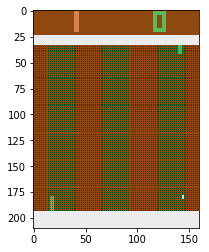

In [4]:
plt.imshow(observation)
plt.show()

In [2]:
up_probability

0.5